In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [32]:
# Load data
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
val = ds['validation']

In [3]:
#visual class names
info = tfds.builder(f'speech_commands:0.0.{version}').info
class_names = info.features['label'].names
for i,c in enumerate(class_names):
    print(f'{i}: {c}')
    

0: down
1: go
2: left
3: no
4: off
5: on
6: right
7: stop
8: up
9: yes
10: _silence_
11: _unknown_


In [4]:
#create mel spectrogram using tfio
import tensorflow_io as tfio

def create_mel_spectrogram(audio):
    """
    Create a mel spectrogram from an audio tensor.
    
    Args:
    audio (tf.Tensor): A 1D tensor containing the audio samples.
    
    Returns:
    tf.Tensor: A 2D tensor containing the mel spectrogram.
    """
    
    audio = tf.signal.stft(audio, frame_length=255, frame_step=128)
    audio = tf.abs(audio)
    audio = tfio.audio.melscale(audio, rate=16000, mels=128, fmin=0, fmax=8000)
    audio = tf.math.log(audio + 1e-6)
    audio = tf.transpose(audio)
    
    return audio

In [5]:
# Preprocess data
def preprocess_data(sample):
    """
    Preprocess a sample from the dataset.
    
    Args:
    sample (dict): A sample from the dataset.
    
    Returns:
    tuple: A tuple containing the mel spectrogram and the label.
    """
    audio = sample['audio']
    #convert to float32
    audio = tf.cast(audio, tf.float32)
    #make sure audio is 16000 samples
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    spectrogram = create_mel_spectrogram(audio)
    label = sample['label']
    #make label one-hot
    label = tf.one_hot(label, 12)
    
    return spectrogram, label

In [5]:
# # Test preprocess_data
# sample = train.take(1)
# sample = sample.map(preprocess_data)

In [41]:
# Create dataset
train_samples = train
train_data = train_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [16]:
print(train)

<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [17]:
print(train_data)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, None), dtype=tf.float32, name=None), TensorSpec(shape=(12,), dtype=tf.float32, name=None))>


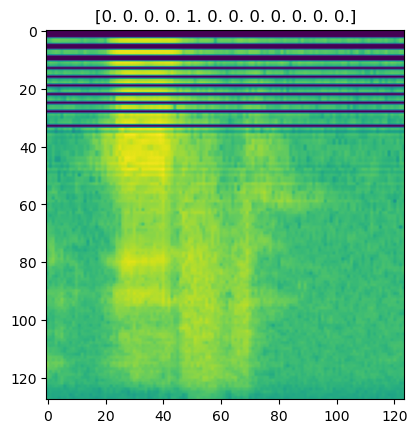

In [18]:
#visualize data
import matplotlib.pyplot as plt
for spectrogram, label in train_data:
    plt.figure()
    plt.imshow(spectrogram.numpy())
    plt.title(label.numpy())
    plt.show()
    break

In [19]:
#evaluate input shape
for spectrogram, label in train_data:
    if spectrogram.shape != (128, 124):
        print(spectrogram.shape)

2024-06-30 12:41:23.208806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
#batch
train_data = train_data.batch(32)

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(num_classes=12):
    """
    Defines a CNN model for audio classification using mel spectrograms.

    Args:
        num_classes: The number of classes in your classification problem (default is 12).

    Returns:
        A compiled TensorFlow Keras model.
    """
    inputs = layers.Input(shape=(128, 124))

    # Reshape input to 4D tensor
    x = layers.Reshape((128, 124, 1))(inputs)
    
    # First convolutional block
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Third convolutional block
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten the tensor output from the convolutional blocks
    x = layers.Flatten()(x)
    
    # Fully connected layers with dropout
    x = layers.Dense(128, activation="relu")(x)
    # x = layers.Dropout(0.5)(x)  # Adjust dropout rate as needed
    
    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [49]:
# Build the model
model = build_model()
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 124)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 128, 124, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 124, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,932,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,027,404 (15.36 MB)

 Trainable params: 4,026,956 (15.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [50]:
#preprocess validation data
val_samples = val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_samples = val_samples.batch(32)

In [51]:
# Train the model
model.fit(train_data,validation_data= val_samples, epochs=3)  # Adjust epochs as needed

Epoch 1/3
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 177s 65ms/step - accuracy: 0.6268 - loss: 1.5812 - val_accuracy: 0.6816 - val_loss: 1.0231
Epoch 2/3
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 175s 66ms/step - accuracy: 0.7400 - loss: 0.7753 - val_accuracy: 0.7958 - val_loss: 0.6040
Epoch 3/3
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 176s 66ms/step - accuracy: 0.8388 - loss: 0.4697 - val_accuracy: 0.8508 - val_loss: 0.4645


In [52]:
# Save the model
model.save("audio_classifier.keras")

In [30]:
# Load the model
model = tf.keras.models.load_model("audio_classifier.keras")

In [53]:
# Test the model
test = ds['test']
test_samples = test # Adjust as needed
test_data = test_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(32)
model.evaluate(test_data)


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6647 - loss: 1.0064


[1.0080727338790894, 0.6715746521949768]